In [1]:
#!pip install tensorflow

In [2]:

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow. keras.preprocessing import image
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Model

In [3]:
data=pd.read_csv("labels.txt", sep=" ", names=['image','attr1','attr2','attr3','attr4'])
data

,image,attr1,attr2,attr3,attr4
0,image_0.jpg,1.0,NaN,0.0,1.0
1,image_1.jpg,NaN,0.0,0.0,0.0
2,image_2.jpg,1.0,1.0,0.0,0.0
3,image_3.jpg,1.0,1.0,0.0,0.0
4,image_4.jpg,1.0,1.0,0.0,0.0
...,...,...,...,...,...
970,image_970.jpg,1.0,1.0,1.0,1.0
971,image_971.jpg,1.0,1.0,0.0,0.0
972,image_972.jpg,1.0,NaN,1.0,0.0
973,image_973.jpg,0.0,1.0,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   975 non-null    object 
 1   attr1   895 non-null    float64
 2   attr2   884 non-null    float64
 3   attr3   882 non-null    float64
 4   attr4   881 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.2+ KB


In [5]:
data.describe()

,attr1,attr2,attr3,attr4
count,895.000000,884.000000,882.000000,881.000000
mean,0.881564,0.806561,0.528345,0.077185
std,0.323304,0.395218,0.499479,0.267036
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


array([<AxesSubplot:title={'center':'attr4'}>], dtype=object)

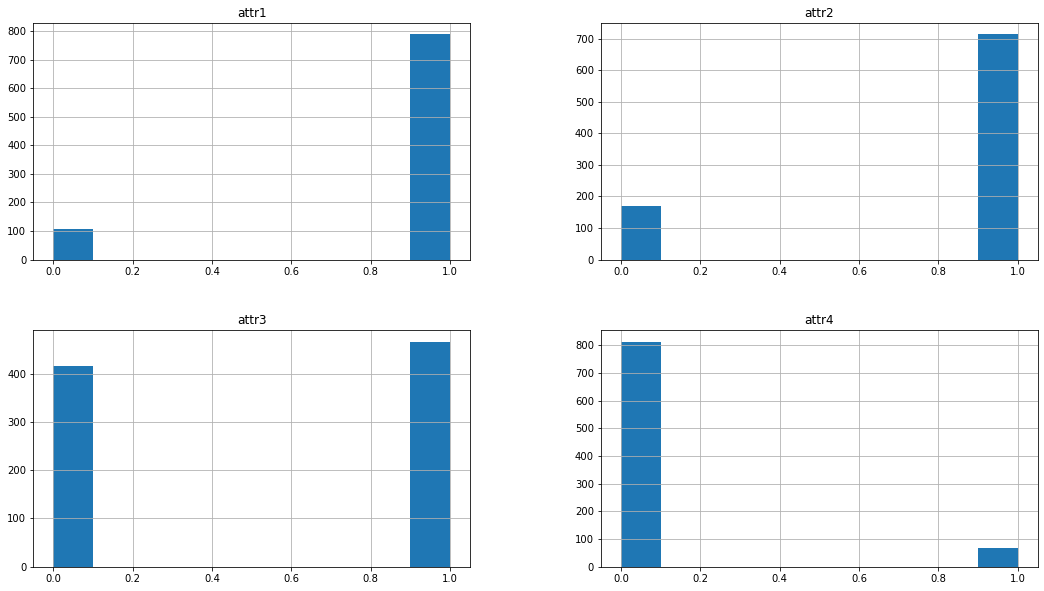

In [14]:
fig, axes = plt.subplots(2,2, figsize=(18, 10))
data.hist('attr1',ax=axes[0,0])
data.hist('attr2',ax=axes[0,1])
data.hist('attr3',ax=axes[1,0])
data.hist('attr4',ax=axes[1,1])


In [19]:
for col_name in data.columns: 
    print ("column:",col_name,".Missing:",sum(data[col_name].isnull()))

column: image .Missing: 0
column: attr1 .Missing: 80
column: attr2 .Missing: 91
column: attr3 .Missing: 93
column: attr4 .Missing: 94


In [53]:
for col_name in data.columns:
    data[col_name].fillna(data[col_name].mode()[0], inplace=True)


In [54]:
for col_name in data.columns: 
    print ("column:",col_name,".Missing:",sum(data[col_name].isnull()))

column: image .Missing: 0
column: attr1 .Missing: 0
column: attr2 .Missing: 0
column: attr3 .Missing: 0
column: attr4 .Missing: 0


In [29]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 5s 0us/step


In [30]:
for layer in vgg.layers:
  layer.trainable = False

In [33]:
x = Flatten()(vgg.output)

In [34]:
prediction = Dense(4, activation='softmax')(x)

In [37]:
model = Model(inputs=vgg.input, outputs=prediction)

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
image_directory = 'images/'
X_dataset = []  
for i in tqdm(range(data.shape[0])):
    img = image.load_img(image_directory+data['image'][i], target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)
    
X = np.array(X_dataset)

100%|██████████| 975/975 [00:07<00:00, 132.21it/s]


In [88]:
y = np.array(data.drop(['image'], axis=1))
y.shape

(975, 4)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [128]:

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

NameError: name 'create_model' is not defined

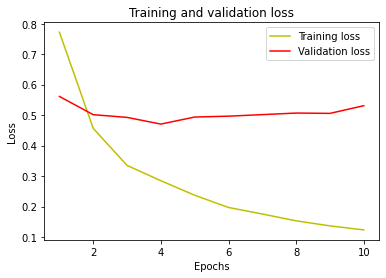

In [60]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

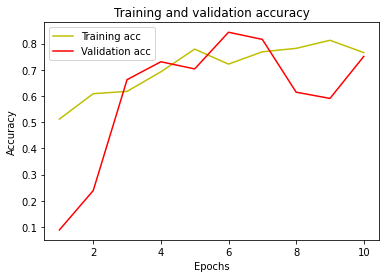

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [62]:
history.history

{'loss': [0.7718652486801147,
  0.4564078450202942,
  0.3350755274295807,
  0.28485336899757385,
  0.23724640905857086,
  0.19715091586112976,
  0.17570623755455017,
  0.15336193144321442,
  0.13676097989082336,
  0.12351454049348831],
 'accuracy': [0.5117301940917969,
  0.6085044145584106,
  0.6173020601272583,
  0.6920821070671082,
  0.7785923480987549,
  0.7214076519012451,
  0.7683284282684326,
  0.7815249562263489,
  0.8123167157173157,
  0.7653958797454834],
 'val_loss': [0.5612518787384033,
  0.5014795064926147,
  0.4926281273365021,
  0.4706036448478699,
  0.49378472566604614,
  0.49660035967826843,
  0.5016813278198242,
  0.5068130493164062,
  0.5057275891304016,
  0.530975341796875],
 'val_accuracy': [0.08873720467090607,
  0.2389078438282013,
  0.6621160507202148,
  0.7303754091262817,
  0.703071653842926,
  0.8430033922195435,
  0.8156996369361877,
  0.6143344640731812,
  0.5904436707496643,
  0.7508532404899597]}

1/1 [==============================] - 0s 126ms/step
attr1 (0.687)
attr2 (0.184)
attr4 (0.103)
attr3 (0.0253)


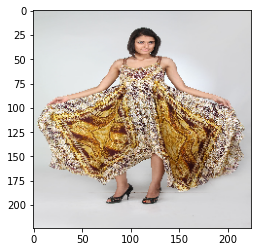

In [104]:
img = image.load_img('images/image_846.jpg', target_size=(224,224,3))

img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(data.columns[1:]) #Get array of all classes
proba = model.predict(img) #Get probabilities for each class

sorted_categories = np.argsort(proba[0])[::-1]  #Get class names for top 10 categories

#Print classes and corresponding probabilities
for i in range(4):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

In [105]:

proba[0]

array([0.6870315 , 0.18445942, 0.02534274, 0.1031663 ], dtype=float32)

In [106]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

10/10 [==============================] - 19s 2s/step - loss: 0.5310 - accuracy: 0.7509
Accuracy =  75.08532404899597 %


In [107]:
proba = np.where(proba > 0.5, 1, 0)
print(proba[0])

[1 0 0 0]


In [134]:
from tensorflow.keras.models import save_model,load_model
save_model(model, "model.h5")
model_p = load_model('model.h5')
model_p.predict(img)

1/1 [==============================] - 0s 218ms/step


array([[0.6870315 , 0.18445942, 0.02534274, 0.1031663 ]], dtype=float32)